In [1]:
import os, re
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
files = [f for f in os.listdir() if re.match("taiga\w*", f)]
xlims = [-5, 5]
ylims = [-5, 5]
Nbins = 100

In [2]:
def intersect(pov1, pov2):
    vec1 = np.array((1, pov1.a))
    vec2 = np.array((1, pov2.a))
    def length(vec):
        return np.sqrt(vec[0] ** 2 + vec[1] ** 2)
    X = (pov2.b - pov1.b)/(pov1.a - pov2.a)
#     print(X)
    Y = pov1.a * X + pov1.b
    theta = np.arccos(np.sum(vec1 * vec2 / length(vec1) / length(vec2)))
    return (X, Y, np.degrees(theta))

def mean_intersect(event):
    povs = [(i, pov) for (i, pov) in enumerate(event.data) if pov]
#     print([(i, pov.width, pov.size, pov.a) for (i, pov) in povs])
    totalsize = np.sum([pov.size for (_, pov) in povs])
    N = len(povs)
    xs = []
    ys = []
    ws = []
    xbins = np.linspace(*xlims, Nbins)
    ybins = np.linspace(*ylims, Nbins)
    for (i, pov1) in povs:
        for (j, pov2) in povs:
            if (i < j):
                x, y, theta = intersect(pov1, pov2)
                w = (pov1.size + pov2.size)/totalsize * np.sin(np.radians(theta))
                xs.append(x)
                ys.append(y)
                ws.append(w)
    hist, _, _ = np.histogram2d(x = xs, y = ys, weights = ws, bins = (xbins, ybins))
#     plt.imshow(hist.T, cmap=plt.cm.viridis)
#     plt.colorbar()
#     plt.show()
    ymean = np.sum([np.sum(xbins[:-1] * i) for i in hist])/Nbins
    xmean = np.sum([np.sum(ybins[:-1] * i) for i in hist.T])/Nbins
#     print(xmean, ymean)
    return (xmean, ymean)

# pov1, pov2 = e.data[0], e.data[4]
# intersect(PoV(a = -3, b = 7), PoV(a = 0.5, b = 1))
# mean_intersect(e)
# pov1, pov2 = PoV(Ntel = 1, size = 100, xc = 100, yc = 150, a = 1, b = 50), PoV(Ntel = 2, size = 100, xc = -100, yc = 100, a = -1, b = 0)

# intersect(pov1, pov2)

In [3]:
class PoV():
    def __init__(self, Ntel = 0, Npix = 0, 
                 size = 0, xax = 0, yax = 0, dist = 0, bound = 0,
                 a = 0, b = 0, alpha = 0, width = 0, xc = 0, yc = 0, length = 0):
        self.Ntel = Ntel
        self.Npix = Npix
        self.size = size
        self.xax = xax
        self.yax = yax
        self.dist = dist
        self.bound = bool(bound)
        self.a = a
        if Npix:
            self.b = b * 0.1206
        else:
            self.b = b
        self.alpha = alpha
        self.width = width
        self.xc = xc #/ 0.1206
        self.yc = yc #/ 0.1206
        self.length = length
    def vizualize(self, colors = ['r', 'y', 'g', 'c', 'b', 'm', 'k'], alpha = 0.3, pixel_coords = None):
        #alpha = 0.3 #параметр для нормирования прозрачности
        fig, ax = plt.subplots(figsize=(7,7))
        # ax.set_title("#"+super().Nevent+"   "+str(self.time), fontsize=16)
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        # ax.scatter(self.source_x, self.source_y, marker = "*", c = "red")
        ellipse = Ellipse((self.xc, self.yc), 
                              2 * self.length,
                              2 * self.width, angle = -alpha, color = "r", alpha = 0.5)
        ax.add_artist(ellipse)
            # print(ellipse)
        if pixel_coords is not None:
            plt.scatter(pixel_coords[pixel][1], pixel_coords[pixel][2], color = colors[(pixel_coords[pixel][0]-1)%7], alpha = 0.1)
        return ax
    
    def core(self):
        return self.Ntel, self.size

class MCEvent():
    def __init__(self, Nevent = 1, Naxis = 0, Ntrig = 1, E = 100, 
                 tel_theta = 0, tel_phi = 0, src_theta = 0, src_phi = 0, 
                 source_x = 0, source_y = 0, xmax = 1000):
        self.Nevent = Nevent
        self.Naxis = Naxis
        self.Ntrig = Ntrig
        self.E = E
        self.tel_theta = tel_theta
        self.x = source_x * 0.1206
        self.y = source_y * 0.1206
        self.xmax = xmax
        self.data = [None for i in range(5)]
    def add(self, pov = PoV()):
        self.data[pov.Ntel] = pov
    def count(self):
        z = 0
        for pov in self.data:
            if pov:
                z += 1
        return z
    def vizualize(self, colors = ['r', 'y', 'g', 'c', 'b', 'm', 'k'], alpha = 0.3, pixel_coords = None):
        #alpha = 0.3 #параметр для нормирования прозрачности
        fig, ax = plt.subplots(figsize=(7,7))
        # ax.set_title("#"+super().Nevent+"   "+str(self.time), fontsize=16)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        xes = np.linspace(-5, 5, 20)
        # ax.scatter(self.source_x, self.source_y, marker = "*", c = "red")
        for pov in self.data:
            if pov:
                ax.plot(xes, pov.a * xes + pov.b, ":m")
                ellipse = Ellipse((pov.xc, pov.yc), 
                                      2 * pov.length,
                                      2 * pov.width, angle = np.degrees(np.arctan(pov.a)),
                                  color = "r", alpha = 0.5)
                ax.add_artist(ellipse)
                ax.text(pov.xc, pov.yc, str(pov.Ntel))
            # print(ellipse)
        ax.scatter(self.x, self.y, marker = '*', c = 'r')
#         if self.count() == 2:
#             pov1, pov2 = [pov for pov in self.data if pov]
#             X, Y, theta = intersect(pov1, pov2)
#             print(X, Y, theta)
        if self.count() > 1:
            X, Y = mean_intersect(self)
            print("Intersect at", "{:.3f} {:.3f}".format(X, Y))
            print("Axis determination error is", "{:.3f}".format(eudist((X, Y), (self.x, self.y))))
            ax.scatter(X, Y, marker = '*', c = 'm')
        if pixel_coords is not None:
            plt.scatter(pixel_coords[pixel][1], pixel_coords[pixel][2], color = colors[(pixel_coords[pixel][0]-1)%7], alpha = 0.1)
        return ax


Intersect at -0.006 0.003
Axis determination error is 0.088


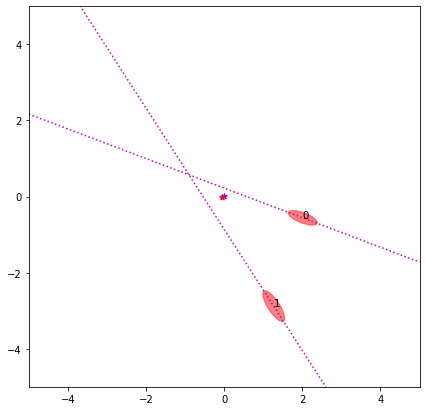

In [7]:
def eudist(a1, a2):
    return np.sqrt((a1[0] - a2[0])**2 + (a1[1] - a2[0])**2)



events = []
for f in files:
    with open(f, "r") as fin:
        while True:
            line = fin.readline().split("\t")
            if line == ['']:
                break
            Nevent, Naxis, Ntrig = map(int, line[:3])
            (E, tel_theta, tel_phi, src_theta, src_phi,
             source_x, source_y, xmax) = map(float, line[3:])
            event = MCEvent(Nevent, Naxis, Ntrig, E, tel_theta, 
                            tel_phi, src_theta, src_phi,
                            source_x, source_y, xmax)
            for trig in range(Ntrig):
                line = fin.readline().split("\t")
                Ntel, Npix = map(int, line[:2])
                (size, xax, yax, dist, bound, a, b, alpha, width, xc, yc, length) = map(float, line[2:-1])
                event.add(PoV(Ntel, Npix, size, 
                              xax, yax, dist, bound,
                              a, b, alpha, width, xc, yc, length))
            events.append(event)
#e =   events[152]
e = events[54]
# e1 = e.data[0]
# e2 = e.data[4]
# print(e1.a, e1.b)
# print(e2.a, e2.b)
# print(e1.xc, e1.yc)
e.vizualize()
pov1, pov2 = [pov for pov in e.data if pov]
ix, iy, _ = intersect(pov1, pov2)
# print(ix, iy)
# print(*[(pov.xax, pov.yax) for pov in e.data if pov])
# print(*[pov.tel_theta for pov in e.data if pov])

In [5]:
def c1(r):
    return 0.1 * r / 1000

def c2(r):
    c = 1.1
    k = -0.00433
    if r > 125:
        return c
    else:
        return c * np.exp(k * (125 - r))
    
def hmax(d, r):
    # km
#     return 1/(c1(r) + c2(r) + np.pi / 180 * d / (r / 1000))
    return c1(r) + r / (np.pi/180 * d) / 1000

def Xmax(h):
    P0 = 1033
    g = 9.807
    R = 8.31
    M = 28.964
    T0 = 273 - 20
    T11 = 273 - 56.5
    gradT = (T11 - T0) / 11
    return P0 * (1 + gradT * h / T0) ** (-g * M / (gradT * R))

heights = []
dists = [pov.dist/np.cos(e.tel_theta) for pov in e.data if pov]
for pov in e.data:
    if pov:
        r = np.sqrt(pov.xax ** 2 + pov.yax ** 2)
        d = pov.dist
        heights.append(Xmax(hmax(d, r)))
print(*zip(heights, dists), sep = '\n')
print()
print(np.mean(heights), np.std(heights), e.xmax)


(206.12073428022006, 2.520874051039355)
(242.5987248290373, 2.490556100278684)
(344.6543947331403, 0.9159716718441164)
(255.51680874731568, 1.1630582627872565)
(322.07707433832155, 2.820369739318391)

274.193547385607 51.45585374860442 368.207


In [6]:
fout = open("mono.txt", "w")
for e in events:
    if e.count() == 1:
        print(e.E, e.Naxis, e.xmax, file = fout)
        for pov in e.data:
            if pov:
                print(pov.Ntel, pov.size, pov.alpha, file = fout)
        print(file = fout)
fout.close()

In [9]:
fout = open("mono.txt", "w")
print('NpxIm', 'sizeIm', 'rc', 'width', 'con2', sep = ',', file = fout)
for e in events:
    if e.count() == 1:
        for pov in e.data:
            if pov:
                print(pov.Npix, pov.size, (pov.xc**2 + pov.yc**2)**0.5, pov.width, file = fout, sep = ',')
fout.close()

In [8]:
for i in range(200):
    if events[i].count() == 2:
        print(i, events[i].count())



1 2
5 2
12 2
17 2
18 2
26 2
36 2
44 2
53 2
54 2
59 2
61 2
66 2
70 2
84 2
97 2
116 2
120 2
124 2
129 2
131 2
132 2
134 2
138 2
151 2
155 2
175 2
183 2
185 2
191 2


In [ ]:
iactx = [108.52, -35.52, 329.61, 210, 519.86]
iacty = [91.3, -197.15, -361.22, -139, 23.46]



# pov1, pov2 = e.data[0], e.data[4]
# intersect(PoV(a = -3, b = 7), PoV(a = 0.5, b = 1))
# mean_intersect(e)
# pov1, pov2 = PoV(Ntel = 1, size = 100, xc = 100, yc = 150, a = 1, b = 50), PoV(Ntel = 2, size = 100, xc = -100, yc = 100, a = -1, b = 0)

# intersect(pov1, pov2)

In [20]:
xmaplims = [-550, 550]
ymaplims = [-550, 550]

iactx = [108.52, -35.52, 329.61, 210, 519.86]
iacty = [91.3, -197.15, -361.22, -139, 23.46]

def intersect(pov1, pov2):
    vec1 = np.array((1, pov1.a))
    vec2 = np.array((1, pov2.a))
    def length(vec):
        return np.sqrt(vec[0] ** 2 + vec[1] ** 2)
    X = (pov2.b - pov1.b)/(pov1.a - pov2.a)
#     print(X)
    Y = pov1.a * X + pov1.b
    theta = np.arccos(np.sum(vec1 * vec2 / length(vec1) / length(vec2)))
    return (X, Y, np.degrees(theta))

def tel_intersect(event):
    povs = [(i, pov) for (i, pov) in enumerate(event.data) if pov]
#     print([(i, pov.width, pov.size, pov.a) for (i, pov) in povs])
    totalsize = np.sum([pov.size for (_, pov) in povs])
    N = len(povs)
    xs = []
    ys = []
    ws = []
    xbins = np.linspace(*xlims, Nbins)
    ybins = np.linspace(*ylims, Nbins)
    for (i, pov1) in povs:
        for (j, pov2) in povs:
            if (i < j):
                x, y, theta = intersect(pov1, pov2)
                w = (pov1.size + pov2.size)/totalsize * np.sin(np.radians(theta))
                xs.append(x)
                ys.append(y)
                ws.append(w)
    hist, _, _ = np.histogram2d(x = xs, y = ys, weights = ws, bins = (xbins, ybins))
#     plt.imshow(hist.T, cmap=plt.cm.viridis)
#     plt.colorbar()
#     plt.show()
    ymean = np.sum([np.sum(xbins[:-1] * i) for i in hist])/Nbins
    xmean = np.sum([np.sum(ybins[:-1] * i) for i in hist.T])/Nbins
#     print(xmean, ymean)
    return (xmean, ymean)

new_event = MCEvent(Ntrig = e.count())
for pov in e.data:
    if pov:
        new_event.add(PoV(Ntel = pov.Ntel, size = pov.size, 
                          a = pov.a, b = pov.b, xc = iactx[Ntel], yc = iacty[Ntel]))
xint, yint = mean_intersect(new_event)
print(xint, yint)

-0.1071151411342407 -0.06897567096568302


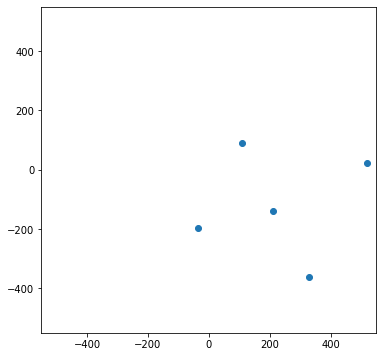

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(*xmaplims)
ax.set_ylim(*ymaplims)

# ax.scatter(xshifts, yshifts)
ax.scatter(iactx, iacty)
# ax.scatter(xint, yint)

49.9901

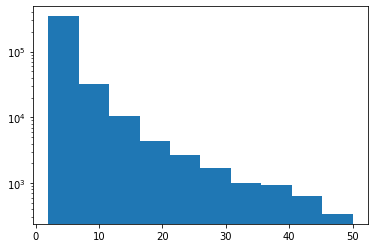

In [9]:
energies = []
with open("list_events599.txt", "r") as fin:
    while True:
        line = fin.readline().split("\t")
        if line == ['']:
            break
        Nevent, Naxis, E = int(line[0]), int(line[1]), float(line[2])
        energies.append(E)
plt.hist(energies, log = True, bins = 10)
np.max(energies)

In [8]:
xerrbins = np.linspace(*xlims, Nbins)
yerrbins = np.linspace(*ylims, Nbins)
errorsx = []
errorsy = []
 
for e in events:
    if e.count() == 2:
        pov1, pov2 = [pov for pov in e.data if pov]
        ix, iy, _ = intersect(pov1, pov2)
        if abs(e.x - iy) < 5:
            errorsx.append(e.x - ix)
        if abs(e.y - iy) < 5:
            errorsy.append(e.y - iy)
# plt.hist(errorsx)

np.min(errorsy)

-4.937454884151634

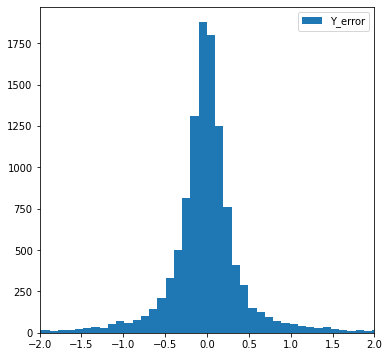

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2, 2)
# ax.set_ylim(0, 2)
ax.hist(errorsy, bins = 100, label = 'Y_error')
# ax.hist(errorsx, bins = 500, label = 'X_error', log = True)
ax.legend()

[ 2.42177297e+06 -2.12877393e+00]


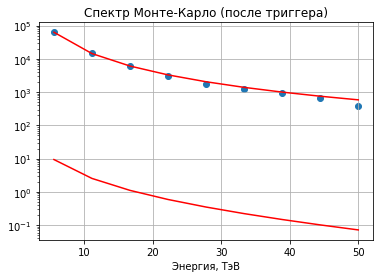

In [12]:
from scipy.optimize import curve_fit
def func(E, A, g):
    return A*E**(g)#*np.exp(-E/E_c)

def exp_cut(E, A = 4.1, g = -1.67, Ec = 37):
    TeV = 1
    return A * (E / (10 * TeV)) ** (g) * np.exp(-E / (Ec * TeV))

def R(E):
    E1 = 10
    

E1, E2 = 0, 50
Nbins = 10
bins = np.linspace(E1, E2, Nbins)
width = (E2 - E1) / Nbins
spectra = np.zeros(Nbins)
for e in energies:
#     i = int(e.E // width)
    i = int(e // width)
    spectra[i] += 1
    
popt, pcov = curve_fit(func, bins[1:], spectra[1:])
plt.scatter(bins[1:], spectra[1:])
plt.plot(bins[1:], func(bins[1:], *popt), c='r')
plt.plot(bins[1:], exp_cut(bins[1:]), c='r')
plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.title("Спектр Монте-Карло (после триггера)")
plt.xlabel("Энергия, ТэВ")
print(popt)

[array([28320.,  9177.,  2548.,  1108.,   596.,   325.,   248.,   199.,
          143.,    79.]),
 array([6596., 2971.,  835.,  417.,  256.,  166.,  121.,   82.,   56.,
          25.]),
 array([2151., 2990., 1096.,  500.,  283.,  166.,  129.,   94.,   77.,
          43.]),
 array([118., 903., 556., 311., 191., 116.,  80.,  69.,  52.,  28.]),
 array([  1., 185., 261., 232., 168., 118.,  98.,  91.,  60.,  49.])]

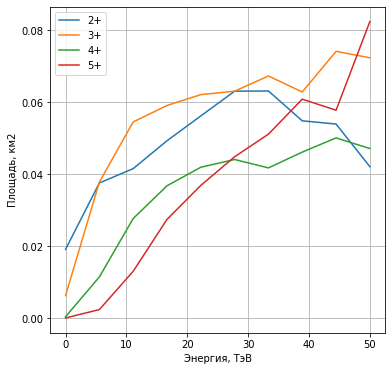

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
registered = [np.zeros(Nbins) for _ in range(5)]
for e in events:
      i = int(e.E // width)
      registered[e.count() - 1][i] += 1
      spectra[i] += 1
# registered = [tel / spectra for tel in registered]
for (i, tel) in enumerate(registered[1:], 2):
    ax.plot(bins, tel/spectra, label = str(i)+'+')
# ax.set_yscale()
ax.legend()
ax.grid()
ax.set_xlabel("Энергия, ТэВ")
ax.set_ylabel("Площадь, км2")
registered

In [16]:
a = [1, 2, 3]
print(a)
print(*a)

[1, 2, 3]
1 2 3
